### <img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393/578 Máquinas de Aprendizaje - 2019-1 </h1>

<H3 align='center'> Tarea 3 - Diego Wilhelm / Tomás Ochoa </H3>
<hr style="height:2px;border:none"/>

<a id="primero"></a>
## 1. Regresión para ubicación espacial

Un problema que tiene aplicaciones para muchos servicios es el cálculo de la ubicación espacial exacta de un dispositivo conectado dentro de un edificio o un complejo de edificios. Estando dentro de un aeropuerto nuestro celular nos podría dar indicaciones para llegar a nuestra puerta de embarque o dentro de un mall para llegar a una tienda, las cuales serían aplicaciones que fácilmente se desprenden de la solución a este problema. Actualmente en exteriores el problema se soluciona fácilmente mediante el uso de GPS, sin embargo en interiores el problema se vuelve más complicado pues hay considerable pérdida de la señal GPS y muchas superficies de construcción pueden resultar reflectantes para algunos tipos de señales por lo cual el problema es mucho más dificil de modelar que el problema en el exterior. 

En esta primera parte de la tarea utilizaremos un _dataset_ creado en 2013 con más de 20000 mediciones de posición dentro de 4 edificios de la universidad de Jaume, disponible en https://archive.ics.uci.edu/ml/datasets/UJIIndoorLoc junto con una detallada descripción. Nuestra tarea será predecir la ubicación espacial en latitud, longitud, y altura (en pisos) de los distintos usuarios que realizaron esta tarea, a partir de las intensidades de señal medidas por los 520 distintos puntos de acceso inalámbricos. Para esto, probaremos utilizar arboles de regresión, regresión lineal y redes neuronales, comparando los distintos desempeños, ventajas y desventajas de cada aproximación. 

#### 1.a Carga de datos

Se cargan los datos de entrenamiento y validación, juntándolos en un solo DataFrame como muestra el código. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
df_tr = pd.read_csv("UJIndoorLoc/trainingData.csv")
df_val = pd.read_csv("UJIndoorLoc/validationData.csv")
df = shuffle(df_tr.append(df_val))

De los datos entregados luego del _target_ solo consideraremos el tipo de celular utilizado, convirtiéndolo a variables _dummies_.

In [2]:
target_col =  df.columns[[520,521,522]]
attribute_col = df.drop(columns=target_col).columns
target_col =  df.columns[[520,521,522]]
attribute_col = df.drop(columns=target_col).columns
x_un = pd.get_dummies(df.PHONEID)

In [20]:
df.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
17340,100,100,100,100,100,100,100,100,100,100,...,100,-7641.5732,4.865009e+06,3,0,122,2,1,14,1371055141
5566,100,100,100,100,100,100,100,100,100,100,...,100,-7435.0554,4.864878e+06,2,1,206,2,9,14,1371714907
14557,100,100,100,100,100,100,100,100,100,100,...,100,-7372.8030,4.864849e+06,1,2,106,2,15,11,1371721766
14604,100,100,100,100,100,100,100,100,100,100,...,100,-7373.0528,4.864845e+06,1,2,116,2,15,11,1371721713
490,100,100,100,100,100,100,100,100,100,100,...,100,-7340.5246,4.864758e+06,3,2,244,2,2,23,1371716818


*Comentario: Adicional al tipo de teléfono del usuario, las features constan de distintas señales WAP, entregando valores enteros negativos entre -104 y 0, al no ser detectadas se presentará el valor positivo +100, como se aprecia muchas veces estas señales no son detectadas por lo que se ve una gran concentración de valores +100.*

Se separa el _target_ del resto de los datos.

In [3]:
categorical_columns = x_un.columns
x_un[attribute_col] = df[attribute_col]
y_un = df[target_col]

Se muestra a continuación el __target__

In [4]:
y_un.describe()

,LONGITUDE,LATITUDE,FLOOR
count,21048.000000,2.104800e+04,21048.000000
mean,-7467.702771,4.864873e+06,1.669137
std,124.084870,6.746981e+01,1.212608
min,-7695.938755,4.864746e+06,0.000000
25%,-7601.616200,4.864821e+06,1.000000
50%,-7425.661100,4.864854e+06,2.000000
75%,-7359.331100,4.864930e+06,3.000000
max,-7299.786517,4.865017e+06,4.000000


Se separan los datos a partir de su índice, dejando un 80% de datos en el _train set_ y un 20% de validación.

In [5]:
x_tr_un = x_un.iloc[0:16838]
y_tr_un = y_un.iloc[0:16838]
x_val_un = x_un.iloc[16838:]
y_val_un = y_un.iloc[16838:]
print(round(100 * x_tr_un.count()[0] / x_un.count()[0]), round(100* x_val_un.count()[0] / x_un.count()[0]))

80.0 20.0


*Comentario: Es posible realizar una separación de los datos a partir del índice, esto ya que los indices han perdido el sentido de orden original al realizar shuffle sobre los datos al momento de cargarlos. De no haberse hecho este reordenamiento de los datos, los índices aún tendrían el significado de orden original, y terminaríamos con un split de datos inhomogenea, siendo la naturaleza del conjunto de entrenamiento distinta a la del de validación, lo cual llevaría a los modelos que se implementen a tener un pobre rendimiento de validación en comparación con el de entrenamiento.*

#### 1.b Estandarización de los datos

Se utiliza _Standard Scaler_ para los atributos no categóricos y para los datos categóricos simplemente se sustrae 0.5, como muestra el código.

*Comentario: La estandarización de datos binarios no tiene sentido, esto debido a que solo existen 2 valores posibles en este tipo de datos, al realizar una estandarización a este tipo de variables al buscar que los datos asuman promedio 0 y desviación estándar 1, si ambas clases están desbalanceadas, la distancia entre ambas clases 1 y 0 se tornará $1/s$, donde $s$ es la desviación estándar original de la data, el punto medio entre ambas clases será distinto de 0 y se corre el peligro que el valor que asuma la clase del 0 ($=\mu/s$) sea un valor demasiado pequeño. En cambio al sustraer simplemente 0.5 se cumplirá que la distancia entre ambas clases se mantenga 1 y el punto medio entre ambas clases sea 0. Esto permitirá evitar el problema de que la clase del 0 no sea manipulable por medio de los coeficientes de un modelo cualquiera, siendo que su valor será -0.5 luego de aplicar la transformación mencionada.*

Se estandariza igualmente el _target_. Cabe mencionar que la tercera componente del target es el piso en el que se encuentra, variable categórica, preferiremos utilizarla como variable continua para ver qué tan bien nuestros algoritmos pueden aproximar la ubicación y para facilitar la comparación de distintos modelos. 

In [6]:
from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler()
scaler_x.fit(x_tr_un[attribute_col])
scaler_y = StandardScaler()
scaler_y.fit(y_tr_un)
x_tr = pd.np.concatenate((scaler_x.transform(x_tr_un[attribute_col]), x_tr_un[categorical_columns].values-0.5), axis=1)
x_val = pd.np.concatenate((scaler_x.transform(x_val_un[attribute_col]), x_val_un[categorical_columns].values-0.5), axis=1) 
y_tr = scaler_y.transform(y_tr_un)
y_val = scaler_y.transform(y_val_un)

#### 1.c Primer Arbol
Entrenaremos ahora un árbol de regresión con produndidad 3. Como métrica utilizaremos el Error Absoluto Medio o MAE a lo largo del resto de esta pregunta.

In [7]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(criterion='mae', max_depth=3)
%timeit -n 1 -r 1 tree.fit(x_tr, y_tr)

1min 37s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Se calcula el score ($R^2$) del regresor tanto en el conjunto de entrenamiento como de validación a continuación.

In [8]:
from sklearn import metrics
tr_score = metrics.r2_score(tree.predict(x_tr), y_tr)
val_score = metrics.r2_score(tree.predict(x_val), y_val)
print("Tree training score:", tr_score)
print("Tree validation score:", val_score)

Tree training score: 0.3819773364065271
Tree validation score: 0.37516312169465954


*Comentario: El error obtenido se encuentra relativamente lejos del óptimo (predicción perfecta) de 1, por lo cual se presiente que la predicción no es de buena calidad bajo esta métrica, la cual se suele utilizar para medir calidad de ajuste de funciones genéricas (polinomiales, exponenciales) a data.*

Se calcula el error absoluto medio de ambos conjuntos

In [9]:
from sklearn.metrics import mean_absolute_error
tr_mae = mean_absolute_error(tree.predict(x_tr), y_tr)
val_mae = mean_absolute_error(tree.predict(x_val), y_val)
print("Tree training MAE:", tr_mae)
print("Tree validation MAE:", val_mae)

Tree training MAE: 0.36994511009143244
Tree validation MAE: 0.373820978322986


*Comentario: Se obtiene un valor que no indica una predicción de tan baja calidad como el caso de $R^2$.*

Se procede a graficar las predicciones del árbol y los valores reales del conjunto de validación (sólo 200 datos por comodidad visual)

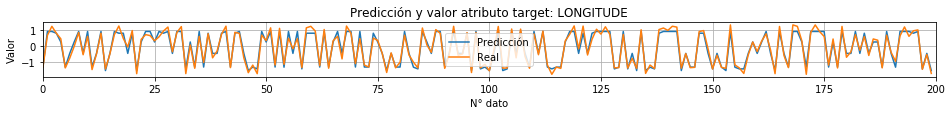

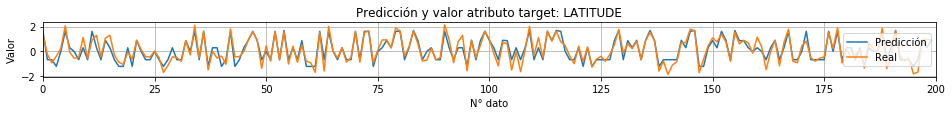

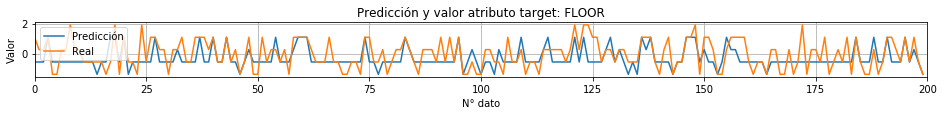

In [10]:
plt.rcParams["figure.figsize"]=[16,1]
for i in range(3):
    plt.plot(tree.predict(x_val)[:200,i],label='Predicción')
    plt.plot(y_val[:200,i],label='Real')
    plt.grid()
    plt.legend()
    plt.title("Predicción y valor atributo target: "+y_tr_un.columns[i])
    plt.ylabel("Valor")
    plt.xlabel("N° dato")
    plt.xlim([0,200])
    plt.show()

*Comentario: Se aprecia que lo que le complica más al modelo es predecir correctamente el piso en que se ubica el usuario.*

Se compara el desempeño del árbol, tanto en MAE como en _score_, en validación y entrenamiento, con respecto a un regresor lineal tradicional.

In [11]:
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression()
%timeit -n 1 -r 1 linear_reg.fit(x_tr, y_tr)

540 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [12]:
tr_score = metrics.r2_score(linear_reg.predict(x_tr), y_tr)
val_score = metrics.r2_score(linear_reg.predict(x_val), y_val)
print("Linear Regression training score:", tr_score)
print("Linear Regression validation score:", val_score)

Linear Regression training score: 0.9490779373009436
Linear Regression validation score: -0.00047500585401927253


*Comentario: Donde se logra un valor de $R^2$ negativo para el conjunto de validación, lo cual indica una pésima predicción, el modelo es peor que un modelo que entregase tan solo el valor medio de la data de validación. Se logra un muy buen score en el conjunto de entrenamiento, casi perfecto. Esto es un claro indicio de overfitting*

In [13]:
tr_mae = mean_absolute_error(linear_reg.predict(x_tr), y_tr)
val_mae = mean_absolute_error(linear_reg.predict(x_val), y_val)
print("Linear Regression training MAE:", tr_mae)
print("Linear Regression validation MAE:", val_mae)

Linear Regression training MAE: 0.1516218034970959
Linear Regression validation MAE: 7866305550.389131


*Comentario: Se ve nuevamente un pésimo score de validación y uno muy bueno de entrenamiento, por lo cual esta métrica también nos indica que el modelo puede estar realizando sobre ajuste.*

Se vuelven a graficar la predicción y valor real para este modelo para 200 datos del conjunto de entrenamiento

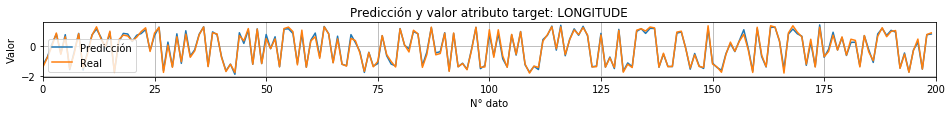

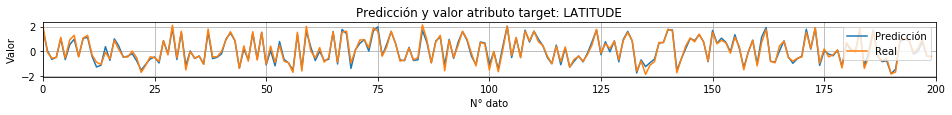

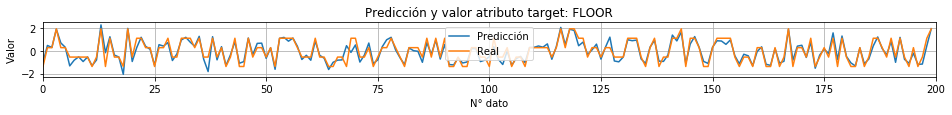

In [40]:
plt.rcParams["figure.figsize"]=[16,1]
for i in range(3):
    plt.plot(linear_reg.predict(x_val)[5:205,i],label='Predicción')
    plt.plot(y_val[5:205,i],label='Real')
    plt.grid()
    plt.legend()
    plt.title("Predicción y valor atributo target: "+y_tr_un.columns[i])
    plt.ylabel("Valor")
    plt.xlabel("N° dato")
    plt.xlim([0,200])
    plt.show()

*Comentario: Visualmente este modelo lo hace mejor que el árbol para estos 200 datos*

Se grafican todos los datos

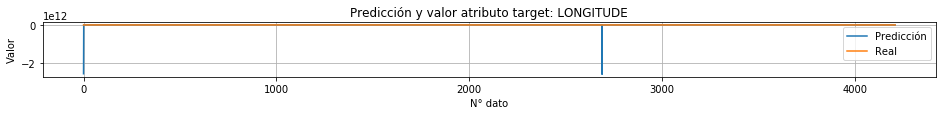

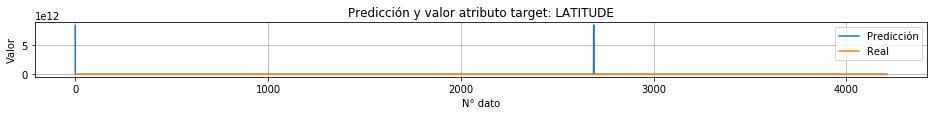

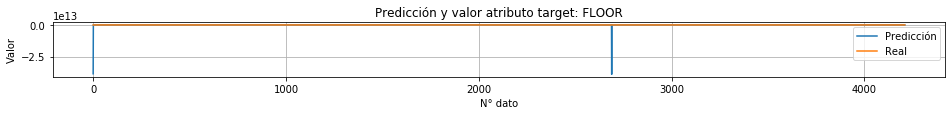

In [15]:
for i in range(3):
    plt.plot(linear_reg.predict(x_val)[:,i],label='Predicción')
    plt.plot(y_val[:,i],label='Real')
    plt.grid()
    plt.legend()
    plt.title("Predicción y valor atributo target: "+y_tr_un.columns[i])
    plt.ylabel("Valor")
    plt.xlabel("N° dato")
    plt.show()

*Comentario: Se aprecia que el modelo lineal presenta casos en que predice valores sobre dimensionados que provocan pobres score $R^2$ y MAE*

Se procede a limitar la predicción del modelo lineal en -2 y 2 y volver a calcular el score y MAE

In [16]:
tr_score = metrics.r2_score(np.clip(linear_reg.predict(x_tr),-2,2), y_tr)
val_score = metrics.r2_score(np.clip(linear_reg.predict(x_val),-2,2), y_val)
print("Linear Regression training score:", tr_score)
print("Linear Regression validation score:", val_score)
tr_mae = mean_absolute_error(np.clip(linear_reg.predict(x_tr),-2,2), y_tr)
val_mae = mean_absolute_error(np.clip(linear_reg.predict(x_val),-2,2), y_val)
print("Linear Regression training MAE:", tr_mae)
print("Linear Regression validation MAE:", val_mae)

Linear Regression training score: 0.9491399457550074
Linear Regression validation score: 0.9336611721495974
Linear Regression training MAE: 0.15115336753440076
Linear Regression validation MAE: 0.1607349823058066


*Comentario: Se aprecia ahora que el modelo lineal funciona de forma mucho mejor que el arbol de decisión luego de adoptar la medida de limitar la predicción. Este problema posiblemente se manifestó debido la presencia de columnas en el conjunto de entrenamiento que asumían un valor único de 100 (el cual luego fue estandarizado), al ser una señal nunca detectada, ajustándose un coeficiente a esta variable que no reaccionó bien al recibir un valor distinto de '100'.*

A continuación se muestra un dato en que se presentó una predicción de gran valor en el conjunto de validación

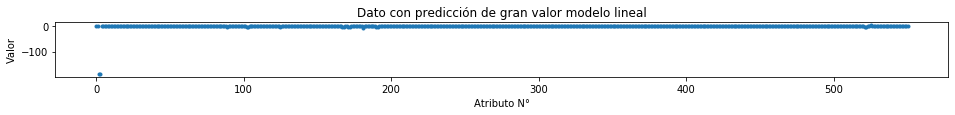

In [17]:
plt.title("Dato con predicción de gran valor modelo lineal")
plt.plot(x_val[np.argmax(linear_reg.predict(x_val)[:,1]),:],'.')
plt.xlabel("Atributo N°")
plt.ylabel("Valor")
plt.show()

Donde se reconocen las señales N° 3 y 4 como valores muy negativos

In [28]:
print(x_val[np.argmax(linear_reg.predict(x_val)[:,1]),2:4])

[-187. -188.]


Luego al ver ambos atributos en el conjunto de entrenamiento se comprueba que ambas señales nunca asumieron un valor distinto a 0.

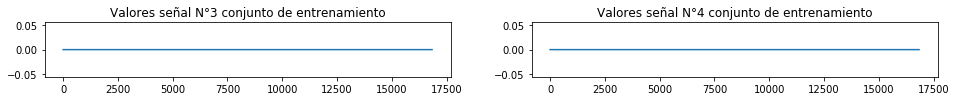

In [34]:
plt.subplot(1,2,1)
plt.title("Valores señal N°3 conjunto de entrenamiento")
plt.plot(x_tr[:,2])
plt.subplot(1,2,2)
plt.title("Valores señal N°4 conjunto de entrenamiento")
plt.plot(x_tr[:,3])
plt.show()

*Comentario: Esto datos son reconocidos como outliers dada la situación, y afectaron enormemente el rendimiento del modelo lineal y no el del árbol de regresión, dado que el árbol se comporta de manera robusta frente a estos outliers*

*Comentario Resumen: Se entrenó un regresor lineal y el árbol con los mismos datos para comparar tiempos de entrenamiento y resultados obtenidos de ambos modelos, como se puede ver el árbol posee una mejor capacidad de generalización al ignorar outliers, el tradeoff está en el tiempo de entrenamiento (1m35s). Aún así el modelo lineal con su salida limitada presenta una mejor predicción que al árbol de regresión y un tiempo de entrenamiento considerablemente menor (547 ms), menos que un 1% de lo que demoró el arbol. Sin embargo cabe preguntarse, si es que esto se va a utilizar para una aplicación... ¿qué tanto importa el tiempo de entrenamiento? Actualizar el modelo en 1m37s sigue siendo veloz. Luego también cabe preguntarse qué hacer con los outliers, su presencia se justifica en la página donde se descargo la data, donde se explica que los valores de las columnas WAP van de -104 a 0, asumiendo el valor +100 cuando no son detectados. Esto será un problema con el cual deberá liar el modelo, pues se asume que entrarán así al modelo. Bien se podría asumir un valor de reemplazo que no sea tan lejano como +100, sino +1 ó +10. Esto no se corregirá por el momento, dado que no se solicita, sin embargo se tendrá en cuento por el resto del ítem 1.*

#### 1.d _Stump_
Se entrena ahora un _Stump_ o arbol de profundidad 1.

In [80]:
stump = DecisionTreeRegressor(criterion='mae', max_depth=1)
%timeit -n 1 -r 1 stump.fit(x_tr, y_tr)

51.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Se calcula el score $R^2$

In [81]:
tr_score = metrics.r2_score(stump.predict(x_tr), y_tr)
val_score = metrics.r2_score(stump.predict(x_val), y_val)
print("Stump training score:", tr_score)
print("Stump validation score:", val_score)

Stump training score: -6.373204924892976e+27
Stump validation score: -4.003782570379343e+27


*Comentario: Se obtiene un score pobre para ambos conjuntos*

In [82]:
tr_mae = mean_absolute_error(stump.predict(x_tr), y_tr)
val_mae = mean_absolute_error(stump.predict(x_val), y_val)
print("Stump training MAE:", tr_mae)
print("Stump validation MAE:", val_mae)

Stump training MAE: 0.5815366101018565
Stump validation MAE: 0.581602694361985


*Comentario: El error MAE es mayor que el del árbol de profundidad 3, consecuencia de la menor complejidad del árbol. A la vez podemos observar que el tiempo de entrenamiento es aproximadamente la mitad del árbol de profundidad 3.*

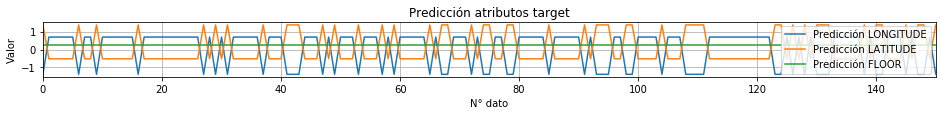

In [83]:
plt.rcParams["figure.figsize"]=[16,1]
for i in range(3):
    plt.plot(stump.predict(x_val)[5:205,i],label='Predicción '+y_tr_un.columns[i])
#     plt.plot(y_val[5:205,i],label='Real')
    plt.grid()
    plt.legend()
    plt.title("Predicción atributos target")
    plt.ylabel("Valor")
    plt.xlabel("N° dato")
    plt.xlim([0,150])
plt.show()

*Comentario: Mientras más profundo sea el árbol, mayor será la cantidad de nodos que este tenga y aumentará considerablemente la cantidad de parámetros del modelo, lo que llevará al overfitting además de tiempos de entrenamiento altos. En este caso se impuso una profundidad de 1, por lo cual ha de existir tan solo 1 nodo. Dada la naturaleza continua de las features el modelo procederá a elegir una variable a la cual realizarle un corte que dará lugar a 2 hojas, donde cada una entregara una combinación de valores de los 3 target las cuales serán las predicciones. En el último gráfico se visualizan estas 2 hojas. Por esto el árbol entrenará para cada hoja 3 constantes (predicción) además de en qué valor realizará el corte a la variable escogida.*

#### 1.e Profundidad máxima
Se exploran distintos valores de la profundidad máxima del árbol. Para esto, se realiza K-fold sobre 10 valores distintos de la profundidad del árbol y se compara el promedio de los MAE de validación. Se guardan los promedios de MAE de _train_ y se grafican como estos varían a medida que varía la profundidad máxima.

In [84]:
from sklearn.model_selection import KFold
rows = x_tr.shape[0]
cols = x_tr.shape[1] + y_tr.shape[1]
folds = KFold(5)
xy_data = np.zeros((rows, cols))
xy_data[:,:-3] = x_tr
xy_data[:,-3:] = y_tr
best_depth = 0
best_val_err = np.inf
val_errors = []
tr_errors = []
tree_depths = np.arange(1,21)
for depth in tree_depths:
    train_errors = []
    validation_errors = []
    for train_index, val_index in folds.split(xy_data):
        y_i = xy_data[:,-3:]
        y_val_i = y_i[val_index]
        y_tr_i = y_i[train_index]
        x_i = xy_data[:,:-3]
        x_val_i = x_i[val_index]
        x_tr_i = x_i[train_index]
        current_model = DecisionTreeRegressor(criterion='mae', max_depth=depth)
        current_model.fit(x_tr_i, y_tr_i)
        train_err = mean_absolute_error(y_tr_i, current_model.predict(x_tr_i))
        val_err = mean_absolute_error(y_val_i, current_model.predict(x_val_i))
        train_errors.append(train_err)
        validation_errors.append(val_err)
    mean_val_err = np.mean(validation_errors)
    mean_tr_err = np.mean(train_errors)
    if (mean_val_err < best_val_err):
        best_depth = depth
        best_val_err = mean_val_err
    val_errors.append(mean_val_err)
    tr_errors.append(mean_tr_err)

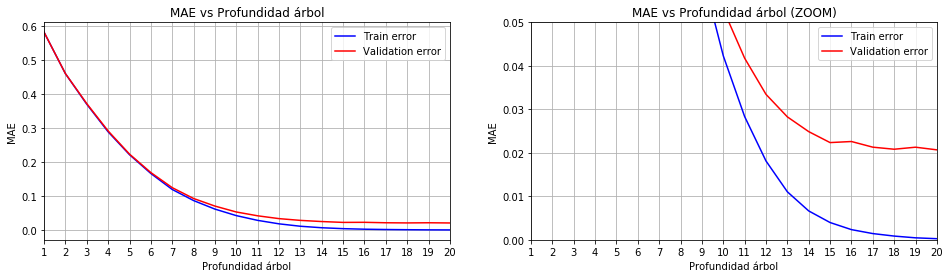

In [97]:
# depth vs mean errors
plt.subplot(1,2,1)
plt.title("MAE vs Profundidad árbol")
plt.rcParams["figure.figsize"]=[16,4]
plt.plot(tree_depths, tr_errors, "b-",label="Train error")
plt.plot(tree_depths, val_errors, "r-",label="Validation error")
plt.legend()
plt.xlabel("Profundidad árbol")
plt.ylabel("MAE")
plt.xticks(np.linspace(1,20,20))
plt.xlim([1,20])
plt.grid()
plt.subplot(1,2,2)
plt.title("MAE vs Profundidad árbol (ZOOM)")
plt.rcParams["figure.figsize"]=[16,4]
plt.plot(tree_depths, tr_errors, "b-",label="Train error")
plt.plot(tree_depths, val_errors, "r-",label="Validation error")
plt.legend()
plt.xlabel("Profundidad árbol")
plt.ylabel("MAE")
plt.xticks(np.linspace(1,20,20))
plt.xlim([1,20])
plt.ylim([0,0.05])
plt.grid()
plt.show()

*Comentario: Se ve que a medida que aumenta la profundidad del árbol se reducen ambos errores (validación y entrenamiento), a la vez que se produce una distancia mayor entre estas, iniciándose a producir sobre ajuste a partir de una profundidad de 15 y casi error de entrenamiento 0 para una profundidad de árbol de 20. Este overfitting se debe a que la cantidad de hojas del árbol es muy grande, dando lugar a que el modelo se "aprenda de memoria" el conjunto de entrenamiento. Es por esto que se produce un error de entrenamiento de aproximadamente 0, ya que el árbol es capaz de representar casi a la perfección todo el conjunto de entrenamiento.*

In [103]:
print("Best depth found was", best_depth)
print("Best depth tree validation MAE:", best_val_err)
print("Best depth tree training MAE:", tr_errors[-1])

Best depth found was 20
Best depth tree validation MAE: 0.020684938602827205
Best depth tree training MAE: 0.0002535412921892036


*Comentario: Pese al sobre ajuste se aprecia para una profundidad de 20 se ve que se logra el mejor error de validación y entrenamiento*

#### 1.f Random Forest

En la pregunta anterior vimos que una profundidad de árbol muy grande puede llevarnos a _overffiting_, pues la cantidad de "decisiones" que puede aprender el modelo aumentan significativamente y el modelo tenderá a aprender de memoria el conjunto de entrenamiento, perdiendo capacidad de generalización. Otra aproximación para evitar producir _overffiting_ es no utilizar todos los datos para entrenar, estrategia implementada por _Random Forest_. 

*Comentario: Random forest consiste en entrenar múltiples árboles, tal como los vistos hasta el momento, con el fin de que cada dato que se desee predecir use las predicciones de todos estos árboles para generar una única predicción (wisdom of the crowds). Con este fin es necesario asegurar que las predicciones de cada árbol entrenado no se encuentre correlacionada con la de los demás árboles, lo que ocurriría si entrenamos cada árbol con la misma data. Para evitar esto random forest entrega a cada árbol data por medio el proceso de bagging, es decir, cada árbol recoge de la data de entrenamiento original muestras aleatorias con reposición, resultando distintos conjuntos de entrenamiento para cada árbol individual.  Adicionalmente, para asegurar mayor variación, se obliga a que cada árbol escoja j features de las I features totales para realizar su predicción, provocando que distintos árboles eligan distintas features para realizar sus cortes en cada nodo.*<br><br>
*Gracias a esto la predicción del random forest, si es que se logra baja correlación entre los árboles, tendrá menor varianza y se logrará evitar sobre ajuste bajo el principio comentado de wisdom of the crowds, ya que se cuenta con múltiples árboles concensuando una única predicción.*

Se procede a entrenar un random forest con profundidad 10. Profundidad escogida arbitrariamente, para lograr encontrar la profundidad óptima debiese hacerse cross-validation como en el punto anterior, y dado que este modelo no tiende a sobre ajustar debiese probarse con un rango de profundidad mayor.

In [109]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=20, criterion='mae', max_depth=10)
%timeit -n 1 -r 1 forest.fit(x_tr, y_tr)

17min 18s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Se calcula el error MAE de este forest, junto a la diferencia de errores de ambos conjuntos y el score obtenido

In [115]:
tr_mae = mean_absolute_error(y_tr, forest.predict(x_tr))
val_mae = mean_absolute_error(y_val, forest.predict(x_val))
print("Forest training MAE:", tr_mae)
print("Forest validation MAE:", val_mae)
print("Fores validation - training error", val_mae-tr_mae)
print("Forest training score (r2):", metrics.r2_score(y_tr, forest.predict(x_tr)))
print("Forest validation score (r2):", metrics.r2_score(y_val, forest.predict(x_val)))

Forest training MAE: 0.1015315915174992
Forest validation MAE: 0.10577563455734203
Fores validation - training error 0.004244043039842826
Forest training score (r2): 0.9723665558390389
Forest validation score (r2): 0.9691216262639211


*Comentario: Se aprecia que el score es ya superior al obtenido por el modelo lineal saturado, a la vez el error de entrenamiento y validación presentan una diferencia del orden de 4e-03, lo cual es indicio de que no se produjo overfitting.*

Y se compara el rendimiento con un árbol único de la misma profundidad

In [116]:
tree10 = DecisionTreeRegressor(criterion='mae', max_depth=10)
%timeit -n 1 -r 1 tree10.fit(x_tr, y_tr)

2min 6s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [118]:
tr10_mae = mean_absolute_error(y_tr, tree10.predict(x_tr))
val10_mae = mean_absolute_error(y_val, tree10.predict(x_val))
print("Tree validation MAE:", val10_mae)
print("Tree training MAE:", tr10_mae)
print("Tree validation - training error", val10_mae-tr10_mae)
print("Tree training score (r2):", metrics.r2_score(y_tr, tree10.predict(x_tr)))
print("Tree validation score (r2):", metrics.r2_score(y_val, tree10.predict(x_val)))

Tree validation MAE: 0.05296700508510554
Tree training MAE: 0.04233636337725096
Tree validation - training error 0.010630641707854577
Tree training score (r2): 0.984431698010939
Tree validation score (r2): 0.9756586482824217


*Comentario: Se aprecia, que se consigue un mejor score y un menor error tanto en el conjunto de entrenamiento y validación que en el caso del random forest en un tiempo menor. Aún así la diferencia de errores es mayor que en el caso de random forest, lo cual siguiendo la lógica del caso anterior, nos indicaría que el random forest sería capaz de lograr mejorar su score y error MAE en ambos conjuntos para profundidades mayores que en el caso de árboles singulares (lo cual se vio en el ítem anterior) al no provocar sobre ajuste.*

#### 1.g Otros parámetros

Por último, se investiga un poco sobre los otros parámetros de los árboles y sus implicancias. Luego, se entrena un arbol modificando algunos de sus parámetros de modo de mejorar su desempeño.

In [290]:
treexp = DecisionTreeRegressor(criterion='mse',
                               max_depth=10000000,
                               min_samples_split=2,
                               min_samples_leaf=2,
                               min_impurity_decrease=1e-8,
                               max_leaf_nodes=int(10000*0.6))
%timeit -n 1 -r 1 treexp.fit(x_tr, y_tr)

1.52 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


*Comentarios: Los parámetros utilizados/cambiados han sido los siguientes...* <br><br>
*__criterion__: Métrica con la que se mide la calidad de los cortes del árbol, la cual consta del mean squared error, la cual permite reducir la varianza y minimizar la pérdida L2 usando el promedio de cada nodo. Y aún más importante permite que el entrenamiento del árbol sea mucho más rápido que en el caso MAE.* <br><br>
*__max_depth__: Profundidad máxima del árbol.* <br><br>
*__min_samples_split__: Mínimo número de muestras requeridas para realizar un corte, este parámetro permite elevar las hojas (más cercas de la raíz) al no permitir que pocos datos puedan crear un corte.* <br><br>
*__min_samples_leaf__: Mínimo número de muestras requeridas para estar en una hoja, este parámetro permite suavizar el modelo.* <br><br>
*__min_impurity_decrease__: Un nodo podrá ser cortado tan solo si es que este corte induce una discminución de impureza mayor o igual que el valor establecido. Este parámetro por lo tanto ayudaría a reducir el número de cortes directamente según su relevancia para la medición de impureza.*<br><br>
*__max_leaf_nodes__: Número máximo de hojas del árbol. Parámetro que permite directamente acortar las hojas del árbol.*<br><br>


*Comentario: Se aprecia que se entrena un árbol de profundidad 1e6, el cual claramente producirá overfitting. El modo de reducir este nivel de sobre ajuste a de ser por medio de los parámetros comentados resultando los siguiente errores MAE y score para los conjuntos de validación y entrenamiento.*

In [298]:
trxp_mae = mean_absolute_error(y_tr, treexp.predict(x_tr))
valxp_mae = mean_absolute_error(y_val, treexp.predict(x_val))
print("Tree validation MAE:", valxp_mae)
print("Tree training MAE:", trxp_mae)
print("Tree validation - training error", valxp_mae-trxp_mae)
print("Tree training score (r2):", metrics.r2_score(y_tr, treexp.predict(x_tr)))
print("Tree validation score (r2):", metrics.r2_score(y_val, treexp.predict(x_val)))

Tree validation MAE: 0.01885062783419805
Tree training MAE: 0.00474932050373976
Tree validation - training error 0.01410130733045829
Tree training score (r2): 0.9989359069322393
Tree validation score (r2): 0.9906467209760992


*Comentario: Si bien el modelo aprendió muy bien los datos de entrenamiento se logró en 1.5 segundos el menor error de validación obtenido en toda la sección, con un score del 99% a la vez, lo cual indica un ajuste excelente para los datos. Se utilizó MAE para comparar con los demás modelos bien el árbol optimiza según MSE.*

Se realiza un 10-Fold para validar el modelo para ser usado en la aplicación

In [294]:
from sklearn.model_selection import KFold
rows = x_tr.shape[0]
cols = x_tr.shape[1] + y_tr.shape[1]
folds = KFold(10)
xy_data = np.zeros((rows, cols))
xy_data[:,:-3] = x_tr
xy_data[:,-3:] = y_tr
val_errors = []
tr_errors = []
for train_index, val_index in folds.split(xy_data):
    y_i = xy_data[:,-3:]
    y_val_i = y_i[val_index]
    y_tr_i = y_i[train_index]
    x_i = xy_data[:,:-3]
    x_val_i = x_i[val_index]
    x_tr_i = x_i[train_index]
    current_model = DecisionTreeRegressor(criterion='mse',max_depth=10000000,min_samples_split=2,min_samples_leaf=2,min_impurity_decrease=1e-8,max_leaf_nodes=int(10000*0.6))
    current_model.fit(x_tr_i, y_tr_i)
    train_err = mean_absolute_error(y_tr_i, current_model.predict(x_tr_i))
    val_err = mean_absolute_error(y_val_i, current_model.predict(x_val_i))
    train_errors.append(train_err)
    validation_errors.append(val_err)
mean_val_err = np.mean(validation_errors)
mean_tr_err = np.mean(train_errors)
r2tr=metrics.r2_score(y_tr_i, current_model.predict(x_tr_i))
r2val=metrics.r2_score(y_val_i, current_model.predict(x_val_i))

In [300]:
print("Training MAE error: ",mean_tr_err)
print("Validation MAE error: ",mean_val_err)
print("Training r2 score: ",r2tr)
print("Validation r2 score: ",r2val)

Training MAE error:  0.004239988187367844
Validation MAE error:  0.022029648636006618
Training r2 score:  0.9988554976251551
Validation r2 score:  0.9880646710901088


*Comentario: El modelo cuenta con la suficiente calidad para ser implementado en la aplicación.*

<a id="segundo"></a>
## 2. Clasificación con clases desbalanceadas

En las tareas de clasificación supervisada, buscamos que mediante los ejemplos etiquetados la máquina pueda aprender los atributos inerentes a las distintas clases. Sin embargo, en muchos casos reales de clasificación, la cantidad de ejemplos de cada clase son muy dispares, en cuyo caso hablamos de clases desbalanceadas. Si uno no aplica estrategias para compensar este problema, la maquina aprenderá muy bien las caracteristicas de la clase más representada pero no logrará extraer información generalizable de la clase menos representada. Además, debemos tener cuidado al momento de interpretar las distintas métricas a las cuales tenemos acceso, pues debemos tomar en cuenta el balance de las clases y la naturaleza del problema para evaluar realmente que tan bueno es el desempeño. 



Para esta parte de la tarea utilizaremos el siguiente _dataset_ publicado en Kaggle: https://www.kaggle.com/mlg-ulb/creditcardfraud. Este conjunto de datos contiene unos 285000 ejemplos de transacciones con tarjetas de crédito reales, realizadas en 2013 por clientes europeos. Los datos son totalmente anónimos y son el resultado de un PCA a partir de los datos originales excepto por las columnas `Time` con el tiempo en segundos desde la primera transacción, `Amount` con el monto de la transacción y `Class` que indica si la transacción es fraudulenta o no. La tarea en cuestión consiste en lograr predecir cuando una transacción es fraudulenta o no automaticamente, para así poder detenerla antes de que se termine. Sin embargo, por la naturaleza de las transacciones bancarias, este problema es desbalanceado, de hecho de los 285000 transacciones registradas, solo 492 son fraudulentas! A lo largo de esta pregunta pondremos en evidencia los problemas que se originan de este desbalance de clases y trataremos de dar luces a algunas herramientas que nos permitan sortear esos problemas y cómo medir realmente el desempeño en esta clase de problemas. 

#### 2.a Carga de datos
Se descargan los datos y se cargan usando pandas. Se realiza una exploración rápida de los datos, cuantos datos hay y cómo se reparten sus valores.

In [51]:
import pandas as pd
df = pd.read_csv('creditcard.csv')

In [52]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


*Comentario: Esta base de datos trata de transacciones realizadas durante 2 días por usuarios europeos, presentando 492 transacciones fraudalentas de 284807 (0.172% del total de transacciones es fraudalenta). La utilidad de predecir cuándo una transacción es fraudalenta es evitar que usuarios sean cargados por compras que no han realizado. Las columnas V1,V2,...,V28 corresponden a una extracción PCA de características de las transacciones, la data original es confidencial dada su naturaleza. La columna Time entrega el tiempo en segundos transcurridos desde la primera transacción y la característica Amount entrega el monto de la transacción.*

Se revisa que no existan datos faltantes

In [53]:
import numpy as np
np.asarray(df.isna().sum())

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

Se calculan datos estadísticos acerca de la data

In [54]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


*Comentario: Se resalta que la característica Amount cuenta con transacciones entre 0 a 25691 euros, además de que las características V1,V2,...,V28 se encuentran centadas aproximadamente en 0 con desviaciones estándar que oscilan entre 0 y 2.*

Se cuenta la cantidad de transacciones no fraudalentas y fraudalentas

In [55]:
normal = df.Class[df.Class == 0].count()
fraud = df.Class[df.Class == 1].count()

print("Total non fraudulent transactions: ", normal)
print("Total fraudulent transactions: ", fraud)
print("Percentage of fraudulent transactions: ", 100*fraud/(fraud+normal))

Total non fraudulent transactions:  284315
Total fraudulent transactions:  492
Percentage of fraudulent transactions:  0.1727485630620034


*Comentario: Se comprueba que las clases se encuentran desbalanceadas, contándose con un 0.17% de los datos totales como fraudalentos*

Se grafica la matriz de correlación

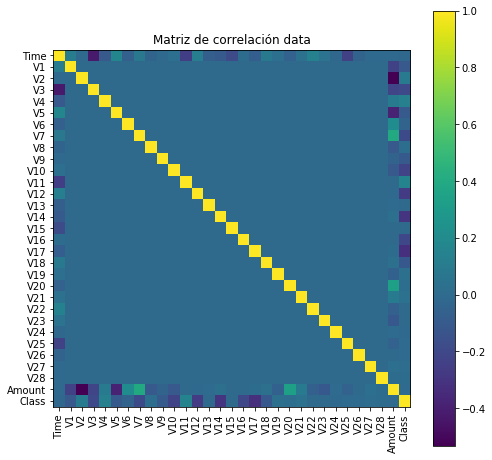

In [56]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=[8,8]
plt.title("Matriz de correlación data")
plt.imshow(df.corr(), cmap='viridis')
plt.xticks(np.arange(31),np.asarray(df.columns),rotation=90)
plt.yticks(np.arange(31),np.asarray(df.columns),rotation=0)
plt.colorbar()
plt.show()

*Comentario: Se aprecia que los datos V1,V2,...,V28 no guardan mayor correlación, de acuerdo a su origen de una descomposición PCA, luego Class el cual indica si la transacción es fraudalenta guarda correlación pequeña con todas las características, llegando a ser negativa en algunos casos. Ahora, la característica tiempo no tiene mucho sentido ocuparla, dado que está en segundos desde la primera transacción, una buena práctica sería utilizar propiedades trigonómetricas para formar una suerte de reloj de 24 horas, haciendo que la hora 23:59 se encuentre previo 'al lado' de la hora 23:58 y 00:00. Bien cabe preguntarse si las transacciones fraudalentas ocurren a cierta hora del día o no, tal vez sí, no sabemos dado que no pertenecemos a este mundo del fraude de tarjetas de créditos, lo que es seguro es que no se puede proceder con el contador de tiempo con el que se cuenta, para esto se procede a formar el 'reloj' el cual requerirá de dos columnas para representar la hora, esto sigue la lógica fasorial.*

In [57]:
tim=np.asarray(df.Time)
def fun(x):
    return [np.sin(2*np.pi*x/(60*60*24)),np.cos(2*np.pi*x/(60*60*24))]

C:\Users\PCSIM-SEP-ZZ\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\PCSIM-SEP-ZZ\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\PCSIM-SEP-ZZ\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\PCSIM-SEP-ZZ\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\PCSIM-SEP-ZZ\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of dat

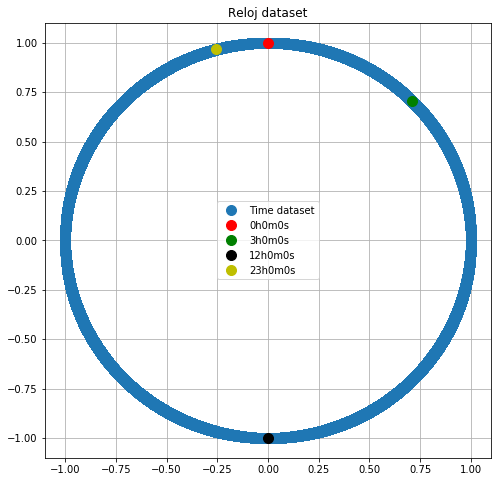

In [60]:
tim0=0
tim1=3*60*60
tim2=60*60*12
tim3=60*60*23
plt.title("Reloj dataset")
plt.plot(np.asarray(fun(tim))[0,:],np.asarray(fun(tim))[1,:],'.',markersize=20,label="Time dataset")
plt.plot(np.asarray(fun(tim0))[0],np.asarray(fun(tim0))[1],'r.',markersize=20,label="0h0m0s")
plt.plot(np.asarray(fun(tim1))[0],np.asarray(fun(tim1))[1],'g.',markersize=20,label="3h0m0s")
plt.plot(np.asarray(fun(tim2))[0],np.asarray(fun(tim2))[1],'k.',markersize=20,label="12h0m0s")
plt.plot(np.asarray(fun(tim3))[0],np.asarray(fun(tim3))[1],'y.',markersize=20,label="23h0m0s")
plt.legend()
plt.grid()
plt.show()

*Comentario: Se aprecia gráficamente cómo funciona el reloj sobre el dataset y proyectando, tal como un reloj de manillas, las horas dentro de una circunferencia, se procede a incorporar ambas columnas en reemplazo de la columna Time y volver a calcular la matriz de correlación*

In [61]:
df = pd.read_csv('creditcard.csv')
df.loc[:,"cos"]=pd.Series(np.asarray(fun(df.Time))[0,:],index=df.index)
df.loc[:,"sin"]=pd.Series(np.asarray(fun(df.Time))[1,:],index=df.index)
df=df.drop(columns="Time")

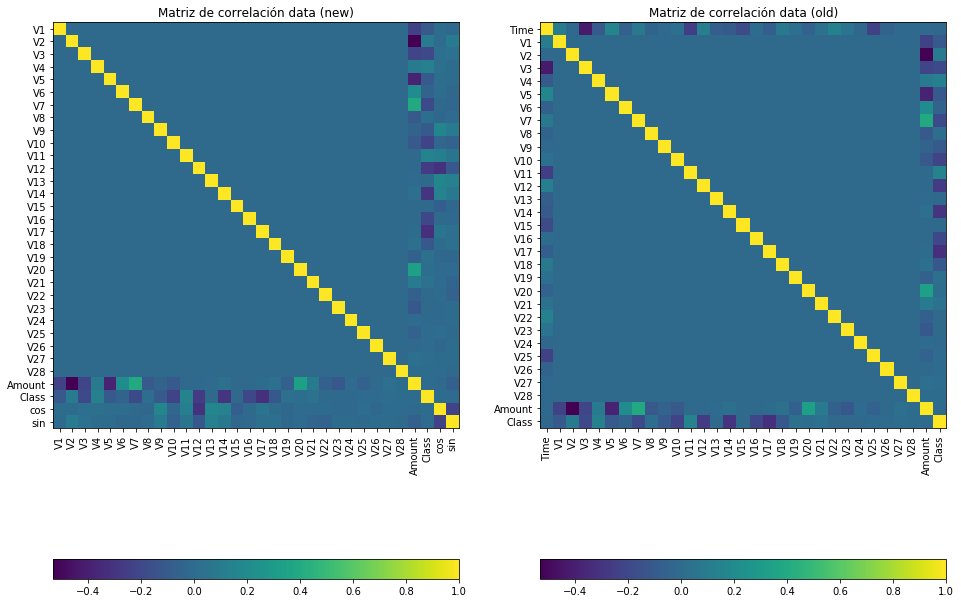

In [62]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=[16,16]
plt.subplot(1,2,1)
plt.title("Matriz de correlación data (new)")
plt.imshow(df.corr(), cmap='viridis')
plt.xticks(np.arange(32),np.asarray(df.columns),rotation=90)
plt.yticks(np.arange(32),np.asarray(df.columns),rotation=0)
plt.colorbar(orientation='horizontal')
plt.subplot(1,2,2)
plt.title("Matriz de correlación data (old)")
dfo = pd.read_csv('creditcard.csv')
plt.imshow(dfo.corr(), cmap='viridis')
plt.xticks(np.arange(31),np.asarray(dfo.columns),rotation=90)
plt.yticks(np.arange(31),np.asarray(dfo.columns),rotation=0)
plt.colorbar(orientation='horizontal')
plt.show()

*Comentario: Se aprecia que disminuyó la negatividad de la correlación entre el tiempo y las demás características al representar el tiempo en dos columnas, mientras la correlación que se guarda con la característica class a predecir es semejante*

#### 2.b Ligero preprocesamiento

* Se escala la columna `Amount`.

In [63]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df['Amount'].values.reshape(-1,1))
df['Amount'] = scaler.transform(df['Amount'].values.reshape(-1,1))

*Comentario: Lo cual es necesario puesto varían entre 0 y 25 mil originalmente, lo cual es no recomendable ya que esto puede generar que el modelo no ajuste correctamente sus coeficientes dadas las características estadísticas de este, se torna más adhoc contar con estos datos con las propiedades estadísticas de promedio 0 y desviación estándar 1. Para las demás features no es tan necesario, pues estos ya poseen promedio 0 y desviación estandar entre 0 y 2. En tanto las columnas de tiempo agregadas también oscilan entre 0 y 1 dada su naturaleza trigonométrica, por lo cual no se considera necesario normalizarla.*

* Se separan los atributos del _target_.
* Luego los datos se dividen en en _Training set_ y _Validation set_, con un 20% de los datos como validación y el resto como _train_. Asegurándose que se mantienen las proporciones de ejemplos de cada clase en ambos sets. 

In [64]:
from sklearn.model_selection import train_test_split
df_0 = df[df.Class == 0]
df_1 = df[df.Class == 1]
df_tr0, df_val0 = train_test_split(df_0, test_size=0.2)
df_tr1, df_val1 = train_test_split(df_1, test_size=0.2)
df_tr = df_tr0.append(df_tr1)
df_val = df_val0.append(df_val1)
y_tr = df_tr.Class
x_tr = df_tr.drop(columns='Class')
y_val = df_val.Class
x_val = df_val.drop(columns='Class')
# Confirmar que tenemos datos de ambas clases en los conjuntos de entrenamiento y validacion
tr_1_count = y_tr[y_tr == 1].count()
tr_0_count = y_tr[y_tr == 0].count()
val_1_count = y_val[y_val == 1].count()
val_0_count = y_val[y_val == 0].count()
print("Percentage of class 0 rows in training set:", 100* tr_0_count / (y_tr.count()))
print("Percentage of class 1 rows in training set:", 100* tr_1_count / (y_tr.count()))
print("Percentage of class 0 rows in validation set:", 100* val_0_count / (y_val.count()))
print("Percentage of class 1 rows in validation set:", 100* val_1_count / (y_val.count()))

Percentage of class 0 rows in training set: 99.82751431894489
Percentage of class 1 rows in training set: 0.17248568105510326
Percentage of class 0 rows in validation set: 99.82619992275552
Percentage of class 1 rows in validation set: 0.17380007724447877


* Qué ocurriría si por ejemplo todos los ejemplos de la clase 1 quedaran en el _validation set_, que haría cualquier máquina de aprendizaje al aprender solo con la clase 0?
*Comentario: Se daría lugar a que el modelo no aprenda a generalizar, dado que no conocería la clase 1 pues no fue entrenada con esta. Luego al validar el modelo rendiría de forma deplorable pues sería data totalmente ajena con la que fue entrenada*

#### 2.c Regresor logístico

Se entrena un regresor logístico con los datos obtenidos de la pregunta anterior y se calcula su desempeño (_score_ por ahora) sobre los datos de validación.

In [70]:
# Regresion logistica
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(solver='lbfgs')
reg.fit(x_tr, y_tr)
reg.score(x_val, y_val)

0.9991924440855307

*Comentario: El modelo logra un score que indica un gran rendimiento, prácticamente perfecto*

#### 2.d _Always_ 0

Suponiendo un modelo que entrega como resultado en el conjunto de validación el siguiente siempre 0 se evalúa el accuracy de este modelo. 

In [68]:
y_pred = pd.np.zeros(y_val.shape)
correct_count = y_val[y_val == y_pred].count()
print("Accuraccy del predictor:", correct_count/y_val.count())

Accuraccy del predictor: 0.9982619992275552


*Comentario: Este predictor es simplemente predecir clase 0 siempre, lo cuál obviamente no es una predicción aceptable, sin embargo podemos ver que su accuracy es muy alta, esto es simplemente debido a que esta métrica no es adecuada para evaluar modelos de clasificación casos como este, en el que tenemos que una de las dos clases es mucho más escasa que la otra. Debemos buscar otras métricas que nos permitan evaluar el desempeño de nuestr modelo en estos casos.*

#### 2.e Matriz de confusión

Se investiga un sobre los valores que conforman la matriz de confusión o _confusion matrix_.

Se procede a escribir una función que a partir de un modelo o de los valores predecidos por un modelo grafique la matriz de confusión. 

In [69]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve
def conf_matrix(model, X_test, y_test, divide = False):
    if divide:
        d = len(X_test)
    else:
        d = 1
    sns.heatmap(confusion_matrix(y_test, model.predict(X_test))/d, cmap='winter', annot=True)    
def conf_matrix_pred(y_pred, y_test):
    y = y_test.reset_index().Class
    q11 = 0 # verdaderos negativos
    q12 = 0 # falsos positivos
    q21 = 0 # falsos negativos
    q22 = 0 # verdaderos positivos
    for i in range(len(y_pred)):
        if (y[i] == 0 and y_pred[i] == 0):
            q11 += 1
        elif (y[i] == 1 and y_pred[i] == 1):
            q22 += 1
        elif (y[i] == 1 and y_pred[i] == 0):
            q12 += 1
        elif(y[i] == 0 and y_pred[i] == 1):
            q21 += 1
    matrix = [[q11, q12],[q21, q22]]
    sns.heatmap(matrix, cmap='winter', annot=True)
    plt.show()

Se procede a graficar la matriz de confusión para la regresión logística realizada en el punto c y para los valores `y_pred` siempre 0 del punto d.

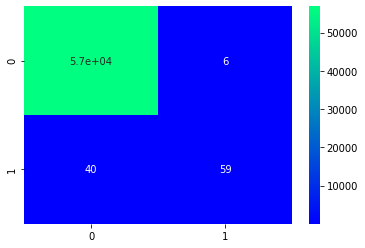

In [71]:
plt.rcParams["figure.figsize"]=[6,4]
conf_matrix(reg, x_val, y_val)
plt.show()

*Comentario: Podemos ver en esta matriz de confusión los resultados de la regresión logística, idealmente queremos que nuestro modelo sea capaz de predecir correctamente todos los casos de la diagonal de la matriz, es decir que los verdaderos positivos y verdaderos negativos sean valores altos, mientras que los falsos positivos y falsos negativos sean lo más cercanos a 0 posible.*

*Esta matriz muestra que nuestra regresión logística es capaz de predecir correctamente la mayoría de los casos en los que la transacción no es un fraude, con una cantidad de errores menor a los aciertos, aunque cuando la regresión predice la transacción como fraude, no tenemos tanta certeza en esta predicción como cuando la regresión predice la transacción como segura. Esto ya que aproximadamente $1/2$ de las veces que la regresión predice fraude, esta se equivoca.*

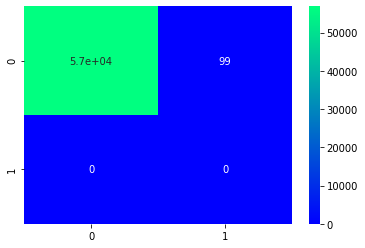

In [223]:
conf_matrix_pred(y_pred, y_val)
plt.show()

*Comentario: En esta matriz de confusión, correspondiente al predictor que solo predice las transacciones como seguras, y nunca predice fraude. Si bien vimos que su accuraccy era alto, podemos ver claramente de que esto se debe solo a que la gran mayoría de las transacciones no son fraudes. Queda claro que si bien los scores eran parecidos, este 'predictor' no se parece a la regresión logística.*

#### 2.f Curva ROC
La curva ROC tiene bastante utilidad para evaluar la calidad de distintos modelos en estos casos. Se investiga un poco sobre su significado para poder interpretarla correctamente y luego se escribe una función que reciba un modelo entrenado y la grafíque. 

Notar que `sklearn` trae implementado una función que entrega los puntos de la curva ROC, eso sí hay que entregarle las probabilidades usando el método `predict_proba` del modelo entrenado. 

Para evaluar distintos modelos se utilizará bastante las curvas ROC y la matriz de confusión, por lo que se procede a escribir una función que reciba un modelo y datos y realice tanto la curva ROC como la matriz de confusión.

In [72]:
#roc_curve
def plot_roc_curve(model, x_ts, y_ts):
    fpr, tpr, _ = roc_curve(y_ts, model.predict_proba(x_ts)[:,1],pos_label=1)
    plt.plot(fpr, tpr,".", label="Curva ROC")
    plt.legend(loc=4)
    plt.xlabel("Razón falsos positivos")
    plt.ylabel("Razón verdaderos positivos")
    plt.grid()
def conf_roc_show(model, x, y, divide = False):
    conf_matrix(model, x, y, divide)
    plot_roc_curve(model, x, y)

Se utiliza la función definida para el modelo de regresión logística.

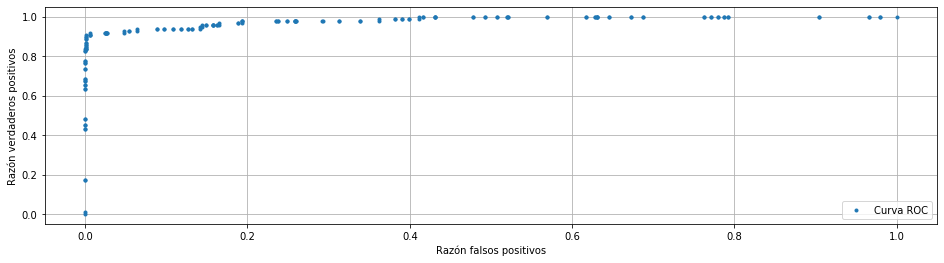

In [73]:
plt.rcParams["figure.figsize"]=[16,4]
plot_roc_curve(reg, x_val, y_val)
plt.show()    

*Comentario: Una interpretación de este gráfico es la representación de la razón o ratio de verdaderos positivos (VPR = Razón de Verdaderos Positivos) frente a la razón o ratio de falsos positivos (FPR = Razón de Falsos Positivos) también según se varía el umbral de discriminación (valor a partir del cual decidimos que un caso es un positivo). ROC también puede significar Relative Operating Characteristic (Característica Operativa Relativa) porque es una comparación de dos características operativas (VPR y FPR) según cambiamos el umbral para la decisión. Un modelo que proporcione una predicción perfecta presentará la mayor área posible pasando por la esquina (0,1) del gráfico mostrado. La razón de verdaderos positivos es la sensibilidad del modelo equivalente a la cantidad de verdaderos positivos dividido por la cantidad de verdaderos positivos más falsos negativos, la razón de falsos positivos es 1-la espeficidad, la cual equivale a la cantidad de verdaderos negativos dividido por la cantidad de verdaderos negativos más la cantidad de falsos positivos. Cada punto de la curva ROC representa distintos cortes probabilísticos del modelo de regresión logística, donde se varía el valor de división entre la clase 0 y 1, el cual suele ser 0.5, sin embargo un excelente modelo debiese predecir la clase 0 como 0 y la clase 1 como 1, no entregando p.ej el valor 0.49 para predecir la clase 0. Un modelo de bajísima calidad entregaría una curva de 45° conectando (0,0) con (1,1)*

*Podemos ver que la curva nos indica que el modelo se desempeña de buen modo*

#### 2.g Arbol de Clasificación
Se entrenan árboles de clasificación para tratar de resolver el problema, probando unas cuantas profundidades máximas distintas.

In [74]:
from sklearn.tree import DecisionTreeClassifier
tree1 = DecisionTreeClassifier(criterion='gini', max_depth=1)
tree3 = DecisionTreeClassifier(criterion='gini', max_depth=3)
tree5 = DecisionTreeClassifier(criterion='gini', max_depth=5)
tree7 = DecisionTreeClassifier(criterion='gini', max_depth=7)

In [75]:
%timeit tree1.fit(x_tr, y_tr)

1.75 s ± 171 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [76]:
%timeit tree3.fit(x_tr, y_tr)

5.25 s ± 308 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [77]:
%timeit tree5.fit(x_tr, y_tr)

8.67 s ± 172 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [78]:
%timeit tree7.fit(x_tr, y_tr)

11.2 s ± 1.33 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


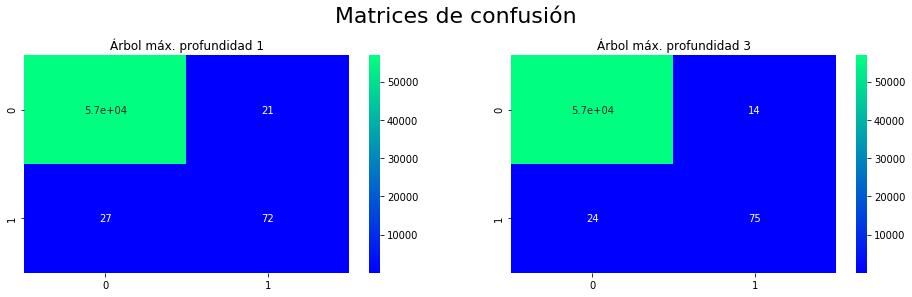

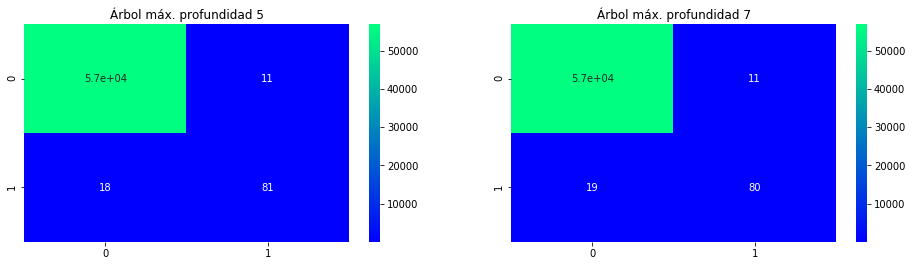

In [79]:
plt.suptitle("Matrices de confusión",size=22,y=1.05)
plt.subplot(1,2,1)
plt.title("Árbol máx. profundidad 1")
conf_matrix(tree1, x_val, y_val)
plt.subplot(1,2,2)
plt.title("Árbol máx. profundidad 3")
conf_matrix(tree3, x_val, y_val)
plt.show()
plt.subplot(1,2,1)
plt.title("Árbol máx. profundidad 5")
conf_matrix(tree5, x_val, y_val)
plt.subplot(1,2,2)
plt.title("Árbol máx. profundidad 7")
conf_matrix(tree7, x_val, y_val)
plt.show()

*Comentario: Se aprecia que ningún modelo entrega una predicción perfecta, bien a medida que aumenta la profundidad máxima del árbol se logra una mayor cantidad de falsos positivos, disminuyendo la cantidad de falsos negativos y verdaderos negativos, este último con excepción del árbol de profundidad 5 que entrega 13 en lugar de 15.*

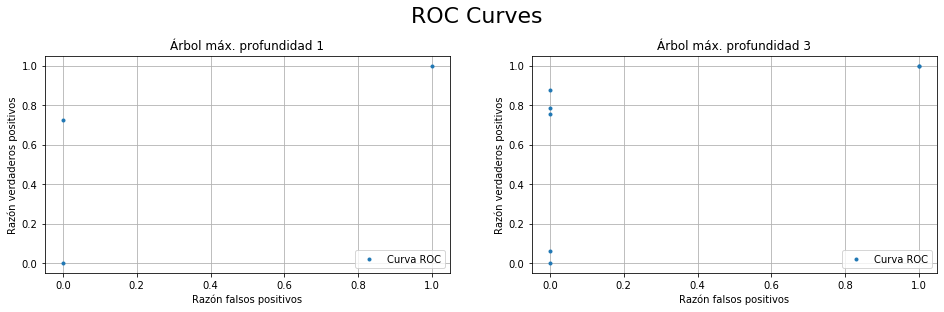

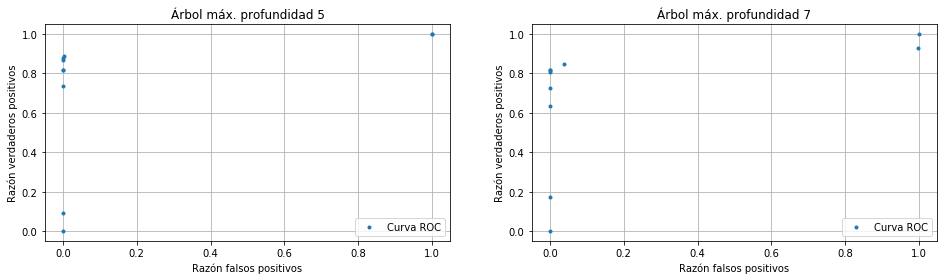

In [80]:
plt.suptitle("ROC Curves",size=22,y=1.05)
plt.subplot(1,2,1)
plt.title("Árbol máx. profundidad 1")
plot_roc_curve(tree1, x_val, y_val)
plt.subplot(1,2,2)
plt.title("Árbol máx. profundidad 3")
plot_roc_curve(tree3, x_val, y_val)
plt.show()
plt.subplot(1,2,1)
plt.title("Árbol máx. profundidad 5")
plot_roc_curve(tree5, x_val, y_val)
plt.subplot(1,2,2)
plt.title("Árbol máx. profundidad 7")
plot_roc_curve(tree7, x_val, y_val)
plt.show()

*Comentario: Dada la profundidad variable del árbol la cantidad de cortes posibles dependerá de la cantidad de hojas generadas, por lo cual se considera que no existen suficientes cortes posibles para variar la razón de verdaderos y falsos positivos para cada árbol, desestimándose el método de curva ROC para seleccionar el mejor árbol. Finalmente, como criterio de selección se opta por elegir el modelo que entrega la mayor cantidad de falsos positivos, siendo este el árbol de mayor profundidad, se aprecia claro en la figura de matrices de confusión cómo mejora el modelo a medida que aumenta la profundidad del árbol.*

#### 2.j _Oversampling_

Otra aproximación para resolver el problema de las clases desbalanceadas es hacer _oversampling_. A partir de una muestra relativamente pequeña de ejemplos, en este caso de los casos de fraude, se busca crear un conjunto de datos más grande similar al inicial, que permita al modelo aprender las características de esa clase, buscando nuevamente obtener clases más balanceadas que originalmente, pero esta vez sin reducir la cantidad de ejemplos. Esta aproximación tiene la ventaja que no reduce la cantidad de ejemplos pero trae la complicación de decidir cómo se van a crear los datos nuevos.

Dos aproximaciones bastante estandar son SMOTE y ADASYN. Se investiga un poco que hace SMOTE e implemente ADASYN.

*Comentario: SMOTE es una combinación de realizar over-sampling con la clase minoritaria y under-sampling con la clase mayoritaria.* <br> <br>
*imblearn.over_sampling.SMOTE(sampling_strategy='auto', random_state=None, k_neighbors=5, m_neighbors='deprecated', out_step='deprecated', kind='deprecated', svm_estimator='deprecated', n_jobs=1, ratio=None)* <br> <br>

*Permite ajustar el proceso por medio de distintos parámetros de estrategia a seguir, número de vecinos considerados para crear datos sintéticos, es posible hasta entregar un estimador SVM...*<br>

*La idea esencial de ADASYN es usar una distribución parametrizada para distintas minorías de clase, donde más data sintética es generada según su dificultad de aprendizaje. Como resultado mejora el aprendizaje con respecto a la distribución de data reduciendo el sesgo introducido por el desbalance de clases, y cambiando adaptativamente la barrera de decisión para la clasificación.* <br>

**¿Por qué cree puede ser deseable buscar que los datos sintéticos no sean linealmente dependientes de los datos originales?** *Al utilizar datos sintéticos dependientes linealmente de los datos originales no se aporta al aprendizaje pues no se estaría enfocando en la zona de decisión donde se mueven lo datos, desplazándola deliberadamente según un factor, si este factor es muy pequeño tan solo se está repitiendo el dato original.*

In [81]:
import sys
sys.path.append("c:\\users\\pcsim-sep-zz\\appdata\\local\\programs\\python\\python37\\lib\\site-packages")

In [150]:
from imblearn.over_sampling import SMOTE, ADASYN
ada = ADASYN(n_neighbors=10)
smo = SMOTE(k_neighbors=10)
x_tr_r1, y_tr_r1 = smo.fit_resample(x_tr, y_tr)
x_tr_r2, y_tr_r2 = ada.fit_resample(x_tr, y_tr)

In [151]:
tree_over1 = DecisionTreeClassifier(criterion='gini', max_depth=7)
tree_over2 = DecisionTreeClassifier(criterion='gini', max_depth=7)

In [152]:
tree_over1.fit(x_tr_r1, y_tr_r1)
tree_over2.fit(x_tr_r2, y_tr_r2)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

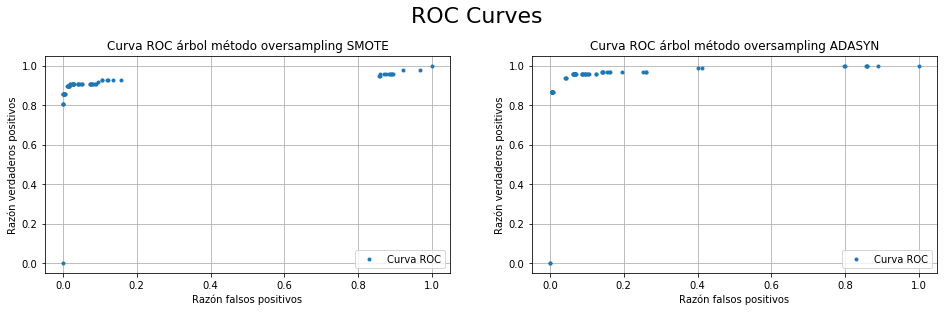

In [153]:
plt.suptitle("ROC Curves",size=22,y=1.05)
plt.subplot(1,2,1)
plt.title("Curva ROC árbol método oversampling SMOTE")
plot_roc_curve(tree_over1, x_val, y_val)
plt.subplot(1,2,2)
plt.title("Curva ROC árbol método oversampling ADASYN")
plot_roc_curve(tree_over2, x_val, y_val)
plt.show()

*Comentario: Se aprecia que en los cortes probabilísticos que muestra ROC ambos métodos presentan un mal rendimiento con los datos verdaderos*

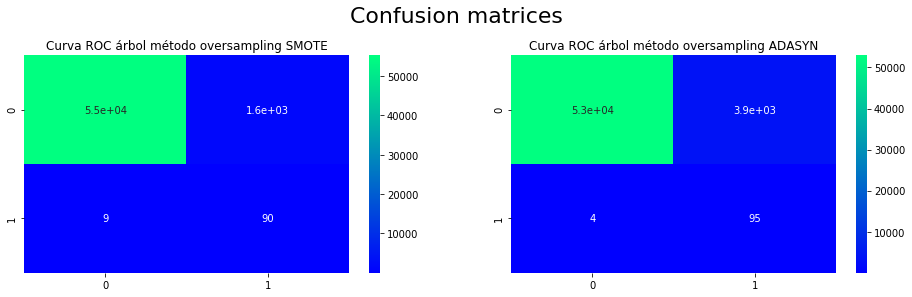

In [184]:
plt.suptitle("Confusion matrices",size=22,y=1.05)
plt.subplot(1,2,1)
plt.title("Curva ROC árbol método oversampling SMOTE")
conf_matrix(tree_over1, x_val, y_val)
plt.subplot(1,2,2)
plt.title("Curva ROC árbol método oversampling ADASYN")
conf_matrix(tree_over2, x_val, y_val)
plt.show()

*Comentario: Se aprecia que ambos métodos fallan, esto al entregar gran cantidad de falsos positivos en el conjunto de validación, aún así aumenta la proporción de fraudes detectados efectivamente, a un precio no menor de fallar al predecir gran cantidad de datos*

#### 2.k Redes neuronales _Feed Forward_ 

Por útimo, probaremos utilizar una red neuronal densa sobre los datos aumentados. Las Redes Neuronales son una herramienta muy poderosa pero comparativamente costosa frente a otros modelos. Entrenar una red neuronal puede resultar muy costoso computacionalmente, por su gran número de parámetros entrenables y por el carácter iterativo de su entrenamiento. Además, el gran numero de parámetros hace que las redes neuronales sean particularmente sensibles al _overfitting_, por lo cual suele ser necesario tener grandes cantidades de datos para poder entrenar una red neuronal obteniendo desempeños que justifiquen su costo adicional.

Por esto, entrenaremos la red neuronal sobre los datos aumentados.

*Comentario: Se utilizan como parámetros: la cantidad de neuronas en la capa oculta (256) y en la capa de salida (1). A la vez se fija como optimizado Adam, medición de error binarycrossentropi, como métrica el accuracy (porcentaje de aciertos), la función de activación de cada capa (relu y sigmoid) y la cantidad de epochs (iteraciones) en que se realiza back propagation (15).*

In [218]:
import keras
import tensorflow as tf
from collections import deque
from keras.layers import Dropout
from keras.optimizers import RMSprop
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.initializers import glorot_normal
from keras import regularizers

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])
history=model.fit(np.asarray(x_tr),np.asarray(y_tr), epochs=5, validation_data=(x_val,y_val))

Train on 227845 samples, validate on 56962 samples
Epoch 1/5
227845/227845 [==============================] - 16s 71us/sample - loss: 0.0065 - acc: 0.9991 - val_loss: 0.0029 - val_acc: 0.9993
Epoch 2/5
227845/227845 [==============================] - 16s 68us/sample - loss: 0.0030 - acc: 0.9994 - val_loss: 0.0022 - val_acc: 0.9994
Epoch 3/5
227845/227845 [==============================] - 16s 70us/sample - loss: 0.0027 - acc: 0.9994 - val_loss: 0.0025 - val_acc: 0.9994
Epoch 4/5
227845/227845 [==============================] - 16s 70us/sample - loss: 0.0026 - acc: 0.9994 - val_loss: 0.0022 - val_acc: 0.9995
Epoch 5/5
227845/227845 [==============================] - 16s 72us/sample - loss: 0.0024 - acc: 0.9995 - val_loss: 0.0024 - val_acc: 0.9994


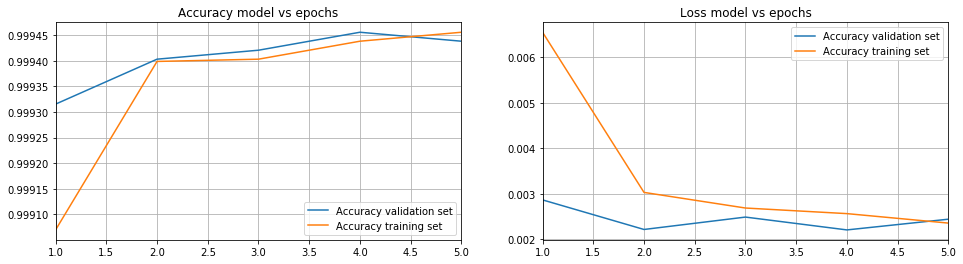

In [223]:
plt.subplot(1,2,1)
plt.title("Accuracy model vs epochs")
plt.plot(np.linspace(1,5,5),history.history['val_acc'],label="Accuracy validation set")
plt.plot(np.linspace(1,5,5),history.history['acc'],label="Accuracy training set")
plt.legend()
plt.grid(),plt.xlim([1,5])
plt.subplot(1,2,2)
plt.title("Loss model vs epochs")
plt.plot(np.linspace(1,5,5),history.history['val_loss'],label="Accuracy validation set")
plt.plot(np.linspace(1,5,5),history.history['loss'],label="Accuracy training set")
plt.legend()
plt.grid(),plt.xlim([1,5])
plt.show()

*Comentario: Se aprecia que mejora el accuracy del modelo a lo largo que se entrena la red neuronal (iteraciones), a la vez en el último epoch se está tendiendo al sobreajuste*

In [224]:
print("Val_loss, Accuracy: ",model.evaluate(x_val, y_val))

56962/56962 [==============================] - 2s 27us/sample - loss: 0.0024 - acc: 0.9994
Val_loss, Accuracy:  [0.0024422965842954927, 0.9994382]


In [225]:
np.asarray(y_val).shape[0]-np.sum(np.round(model.predict(np.asarray(x_val)),0)[:,0]==np.asarray(y_val))

32

*Comentario: Resultan tan solo 32 puntos mal clasificados, logran un rendimiento similar a los árboles de decisión utilizados previamente*

La red neuronal presenta un comportamiento de costo semejante a los árboles de decisión (aprox. 1 min de entrenamiento) y en rendimiento también logra un valor semejante al arbol de clasificación

<a id="tercero"></a>
## 3. Clasificación en texto

Un problema muy complejo, en el cual actualmente se esta avanzando a pasos de gigantes en comparación con los avances de hace unos cuantos años, es en la comprehensión de texto, o de lenguaje natural en general. Nuestra manera de construir significado a partir de las palabras es mucho más compleja de lo que nos damos cuenta y supone un gran grado de conocimiento previo que hemos adquirido a lo largo de nuestras vidas. Lograr que una maquina de aprendizaje pueda extraer significado o interpretaciones a partir de un texto es un problema bastante actual, en el cual aún se hacen avances día a día. En esta pregunta utilizaremos una base de datos de texto, extraida de _reviews_ de peliculas en la página IMDB. Cada uno de estos _reviews_ esta etiquetado como positivo o negativo. Nuestra tarea será predecir esta etiqueta a partir de la secuencia de palabras encodeadas como frecuencias de cada ejemplo.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6a/New-imdb-logo.png/1024px-New-imdb-logo.png"  style="height:6cm;"  />

Para esto probaremos distintas técnicas, incluyendo Perceptron, Redes densas _feed forward_ y ensamblados. Si bien ninguna de estas aproximaciones son las usualmente utilizadas en la actualidad para procesamiento de texto (_words embeddings_, redes recurrentes y redes convolucionales, entre muchos otros), esta pregunta servirá como una buena aproximación a las problematicas usualmente encontradas en estas técnicas y al momento de trabajar con texto. 


#### 3.a Carga de datos

Cargue los datos. Utilizaremos 45000 de los datos como entrenamiento y el resto como validación. Guarde los datos originales luego del _padding_ en un _array_ que utilizaremos más adelante, y cree otro _array_ 2-dimensional con los datos como categorías binarias como muestran las últimas lineas de código.

Lea un poco de la documentación de keras y comente sobre los parámetros utilizados al momento de cargar los datos. ¿Qué realiza la función `pad_sequences`? Comente también sobre sus parámetros.


In [1]:
import sys
sys.path.append("c:\\users\\pcsim-sep-zz\\appdata\\local\\programs\\python\\python37\\lib\\site-packages")
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
num_words=100
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(x_tr_o, y_tr), (x_val_o, y_val) = imdb.load_data(num_words=num_words,skip_top=10,oov_char=0)

# restore np.load for future normal usage
np.load = np_load_old

print("X Shapes", x_tr_o.shape, x_val_o.shape)
print("Y Shapes", y_tr.shape, y_val.shape)

x_tr_o = pad_sequences(x_tr_o, maxlen=100, padding='post', truncating='post',value=0)
x_val_o = pad_sequences(x_val_o, maxlen=100, padding='post', truncating='post',value=0)

print("Padded shapes", x_tr_o.shape, x_val_o.shape)

x_tr_o = np.append(x_tr_o, x_val_o[:20000,],axis=0)
y_tr = np.append(y_tr, y_val[:20000],axis=0)

x_val_o = x_val_o[20000:,]
y_val = y_val[20000:]

print("Final X shapes", x_tr_o.shape, x_val_o.shape)
print("Final Y shapes", y_tr.shape, y_val.shape)

x_tr = to_categorical(x_tr_o, num_classes=num_words).reshape(x_tr_o.shape[0],-1)
x_val = to_categorical(x_val_o, num_classes=num_words).reshape(x_val_o.shape[0],-1)

print("Categorical shapes", x_tr.shape, x_val.shape)

X Shapes (25000,) (25000,)
Y Shapes (25000,) (25000,)
Padded shapes (25000, 100) (25000, 100)
Final X shapes (45000, 100) (5000, 100)
Final Y shapes (45000,) (5000,)
Categorical shapes (45000, 10000) (5000, 10000)


*Comentario:*

*El parámetro num_words de la función de carga de datos indica que se considerarán las num_word palabras más frecuentes.*

*El parámetro skip_top indica que se ignorarán las skip_top palabras más frecuentes*

*El parámetro oov_char reemplaza en las secuencias a las palabras que no se considerarán por los 2 paramétros anteriores*


*La función pad_sequences transforma una lista de listas a un NumPy Array 2D.*

*De sus parámetros max_len indica el largo máximo a considerar de cada secuencia*

*padding indica el tipo de padding a utilizar (previo o posterior a cada secuencia)*

*truncating indica si en el caso de que una secuencia sea mas largo que max_len se remueven elementos del 
comienzo o del final de la secuencia*

*value indica el valor que se agregará en los bordes de la secuencia en el caso de que tenga un largo menor a max_len*


#### 3.b Perceptrón **(Opcional)**
Entrene un perceptrón con activación sigmoidea, optimizador _Stochastic Gradient Descent_, por a lo menos 15 _epochs_, como muestra el código siguiente. 

Discuta sobre la dimensión de `x_tr` y la cantidad de parámetros del modelo deacuerdo al método `.summary` del modelo. 

Grafique el error o el _accuracy_ segun su preferencia, tanto sobre entrenamiento como validación, a medida pasan los _epochs_. Note esta información puede obtenerla desde `history.history`.

In [4]:
from keras.layers import Dense
from keras.models import Sequential

In [5]:
per = Sequential()
per.add(Dense(1,activation='sigmoid'))
per.compile('sgd',loss='binary_crossentropy',metrics=['accuracy'])
history = per.fit(x_tr,y_tr, epochs=15, validation_data=(x_val,y_val))
per.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 7s 155us/step - loss: 0.6923 - acc: 0.5218 - val_loss: 0.6883 - val_acc: 0.5354
Epoch 2/15
45000/45000 [==============================] - 6s 137us/step - loss: 0.6829 - acc: 0.5640 - val_loss: 0.6834 - val_acc: 0.5570
Epoch 3/15
45000/45000 [==============================] - 6s 136us/step - loss: 0.6765 - acc: 0.5857 - val_loss: 0.6797 - val_acc: 0.5710
Epoch 4/15
45000/45000 [==============================] - 6s 133us/step - loss: 0.6708 - acc: 0.6012 - val_loss: 0.6760 - val_acc: 0.5782
Epoch 5/15
45000/45000 [==============================] - 6s 136us/step - loss: 0.6657 - acc: 0.6119 - val_loss: 0.6735 - val_acc: 0.5914
Epoch 6/15
45000/45000 [==============================] - 6s 134us/step - loss: 0.6611 - acc: 0.6214 - val_loss: 0.6713 - val_acc: 0.5830
Epo

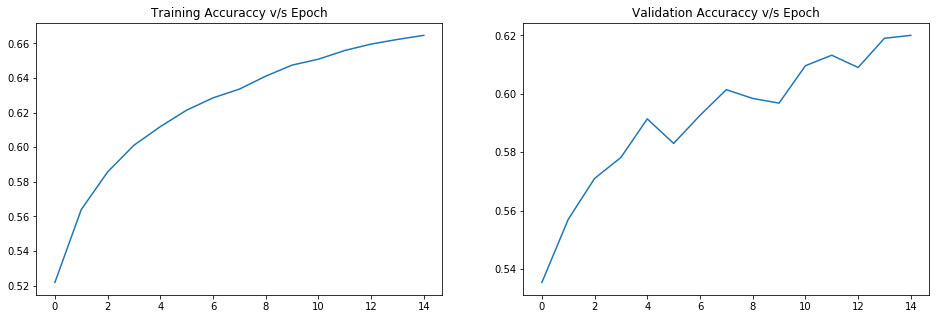

In [6]:
plt.rcParams["figure.figsize"] = [16, 5]

plt.subplot(1,2,1)
plt.title("Training Accuraccy v/s Epoch")
plt.plot(history.history['acc'])
plt.subplot(1,2,2)
plt.title("Validation Accuraccy v/s Epoch")
plt.plot(history.history['val_acc'])
plt.show()

#### 3.c Red con una capa oculta
Ahora, haremos nuevamente un modelo secuencial, al cual le agregarémos una capa oculta con activación ReLu. ¿Qué realiza la función ReLu (puede ejemplificar con gráficos)?

Entrene esta red nuevamente con los mismos parámetros que la red anterior. ¿Mejoran los desempeños? ¿Cuál es el número de parámetros de este modelo? Grafíque nuevamente como varía la métrica a medida pasan las _epochs_. ¿Alcanza a notar sobreajuste?

Cambie la función de activación por otra de su elección (e.g. $tanh$ o activación lineal). ¿Cambia el desempeño? 

Compare finalmente el desempeño con una regresión lineal. ¿Cómo hace la red para obtener representaciones no-lineales que la regresión lineal no puede obtener? ¿Por qué se podría argumentar que una red neuronal densa _feed forward_ tiene un sabor a ensamblado de regresiones lineales en un principio? 

*Comentario:*

*La función ReLu es una función de activación cuya finalidad es ...*

In [6]:
model_relu = Sequential()
model_relu.add(Dense(32, activation='relu'))
model_relu.add(Dense(1,activation='sigmoid'))

model_relu.compile('sgd',loss='binary_crossentropy',metrics=['accuracy'])
history = model_relu.fit(x_tr,y_tr, epochs=15, validation_data=(x_val,y_val))
model_relu.summary()

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 6s 131us/step - loss: 0.6907 - acc: 0.5270 - val_loss: 0.6889 - val_acc: 0.5394
Epoch 2/15
45000/45000 [==============================] - 5s 122us/step - loss: 0.6835 - acc: 0.5637 - val_loss: 0.6893 - val_acc: 0.5348
Epoch 3/15
45000/45000 [==============================] - 6s 124us/step - loss: 0.6751 - acc: 0.5874 - val_loss: 0.6821 - val_acc: 0.5526
Epoch 4/15
45000/45000 [==============================] - 6s 123us/step - loss: 0.6661 - acc: 0.6042 - val_loss: 0.6755 - val_acc: 0.5814
Epoch 5/15
45000/45000 [==============================] - 6s 123us/step - loss: 0.6555 - acc: 0.6235 - val_loss: 0.6681 - val_acc: 0.5812
Epoch 6/15
45000/45000 [==============================] - 6s 127us/step - loss: 0.6447 - acc: 0.6352 - val_loss: 0.6784 - val_acc: 0.5656
Epoch 7/15
45000/45000 [==============================] - 6s 124us/step - loss: 0.6323 - acc: 0.6491 - val_loss: 0.6567 - v

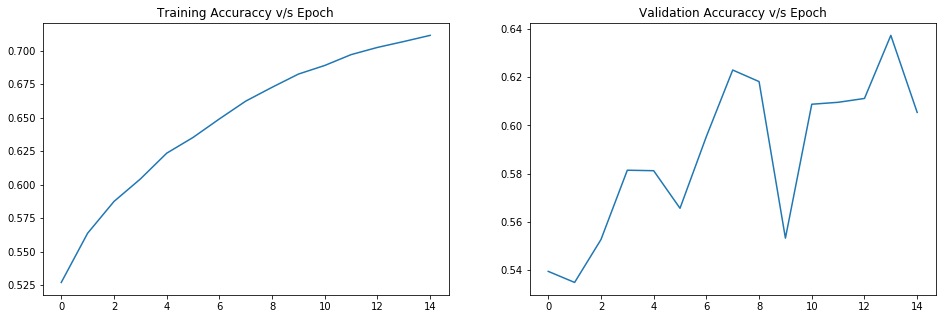

In [7]:
plt.subplot(1,2,1)
plt.title("Training Accuraccy v/s Epoch")
plt.plot(history.history['acc'])
plt.subplot(1,2,2)
plt.title("Validation Accuraccy v/s Epoch")
plt.plot(history.history['val_acc'])
plt.show()

*El modelo posee un total de 320065 parámetros entrenables. Puede observarse que el accuraccy en training del modelo alcanza un valor final de 0.71, lo cuál es una mejora por sobre el accuraccy de 0.66 en el modelo del perceptrón. Al mismo tiempo podemos observar que el accuraccy en validation final de este modelo es de 0.60 versus el 0.62 de validation accuraccy del perceptrón. Podemos finalmente observar que el accuraccy del modelo en training mejora continuamente, mientras que en validation podemos ver una tenendcia a mejorar, pero en algunas epochs este valor puede verse afectado de mala manera con respecto a la epoch anterior.*

In [10]:
model = Sequential()
model.add(Dense(32, activation='tanh'))
model.add(Dense(1,activation='sigmoid'))

model.compile('sgd',loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(x_tr,y_tr, epochs=15, validation_data=(x_val,y_val))
model.summary()

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 6s 133us/step - loss: 0.6903 - acc: 0.5329 - val_loss: 0.7001 - val_acc: 0.4938
Epoch 2/15
45000/45000 [==============================] - 6s 135us/step - loss: 0.6767 - acc: 0.5758 - val_loss: 0.6833 - val_acc: 0.5620
Epoch 3/15
45000/45000 [==============================] - 6s 126us/step - loss: 0.6656 - acc: 0.6019 - val_loss: 0.6798 - val_acc: 0.5718
Epoch 4/15
45000/45000 [==============================] - 6s 131us/step - loss: 0.6542 - acc: 0.6203 - val_loss: 0.6698 - val_acc: 0.5782
Epoch 5/15
45000/45000 [==============================] - 6s 131us/step - loss: 0.6432 - acc: 0.6348 - val_loss: 0.6606 - val_acc: 0.6106
Epoch 6/15
45000/45000 [==============================] - 6s 130us/step - loss: 0.6308 - acc: 0.6498 - val_loss: 0.6553 - val_acc: 0.6036
Epoch 7/15
45000/45000 [==============================] - 6s 137us/step - loss: 0.6199 - acc: 0.6604 - val_loss: 0.6726 - v

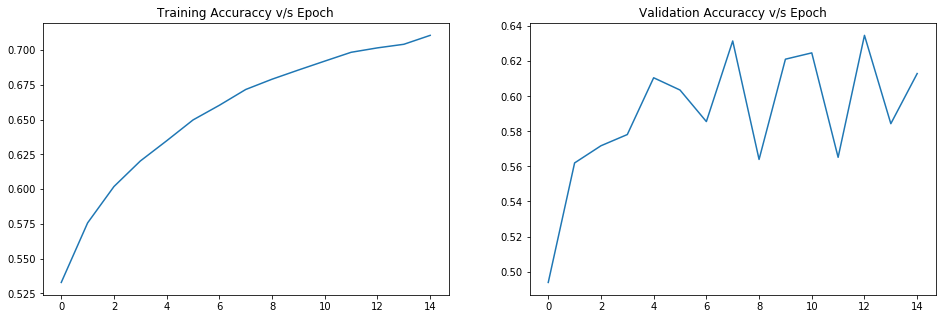

In [11]:
plt.subplot(1,2,1)
plt.title("Training Accuraccy v/s Epoch")
plt.plot(history.history['acc'])
plt.subplot(1,2,2)
plt.title("Validation Accuraccy v/s Epoch")
plt.plot(history.history['val_acc'])
plt.show()

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
reg = LogisticRegression()
reg.fit(x_tr, y_tr)
reg.score(x_val, y_val)

C:\Users\PCSIM-SEP-ZZ\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6378

Compare finalmente el desempeño con una regresión lineal. ¿Cómo hace la red para obtener representaciones no-lineales que la regresión lineal no puede obtener? ¿Por qué se podría argumentar que una red neuronal densa _feed forward_ tiene un sabor a ensamblado de regresiones lineales en un principio? 

#### 3.d Exploración de número de neuronas ocultas

Utilizando la misma estructura de la red entrenada en la pregunta anterior, evalue como varía el _accuracy_ sobre validación y entrenamiento a medida se cambia el numero de neuronas. Explore numeros de neuronas en potencias de 2 entre 2 y 256. En cada iteración debe considerar el mejor _accuracy_ sobre validación y el _accuracy_ de entrenamiento de ese mísmo _epoch_, pues ese sería el modelo que se preferiría. 

Grafique como variaron los _accuracy_ a medida cambió el número de neuronas y discuta. 

In [27]:
accs = []
val_accs = []

for i in range(1,9):
    model = Sequential()
    
    model.add(Dense(units=2**i, activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    
    model.compile('sgd',loss='binary_crossentropy',metrics=['accuracy'])
    history = model.fit(x_tr,y_tr, epochs=15, validation_data=(x_val,y_val))
    
    best = 0
    best_tr = 0
    for j in range(len(history.history['val_acc'])):
        if (history.history['val_acc'][j] > best):
            best = history.history['val_acc'][j]
            best_tr = history.history['acc'][j]
    
    accs.append(best_tr)
    val_accs.append(best)
    

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 4s 80us/step - loss: 0.6932 - acc: 0.5044 - val_loss: 0.6928 - val_acc: 0.5150
Epoch 2/15
45000/45000 [==============================] - 3s 72us/step - loss: 0.6926 - acc: 0.5106 - val_loss: 0.6923 - val_acc: 0.5246
Epoch 3/15
45000/45000 [==============================] - 3s 72us/step - loss: 0.6901 - acc: 0.5305 - val_loss: 0.6895 - val_acc: 0.5442
Epoch 4/15
45000/45000 [==============================] - 3s 74us/step - loss: 0.6838 - acc: 0.5577 - val_loss: 0.6860 - val_acc: 0.5524
Epoch 5/15
45000/45000 [==============================] - 3s 76us/step - loss: 0.6740 - acc: 0.5850 - val_loss: 0.6825 - val_acc: 0.5606
Epoch 6/15
45000/45000 [==============================] - 3s 74us/step - loss: 0.6632 - acc: 0.6094 - val_loss: 0.7000 - val_acc: 0.5150
Epoch 7/15
45000/45000 [==============================] - 3s 78us/step - loss: 0.6522 - acc: 0.6282 - val_loss: 0.6640 - val_acc:

45000/45000 [==============================] - 25s 549us/step - loss: 0.5789 - acc: 0.6995 - val_loss: 0.6399 - val_acc: 0.6262
Epoch 12/15
45000/45000 [==============================] - 25s 548us/step - loss: 0.5663 - acc: 0.7117 - val_loss: 0.6762 - val_acc: 0.6040
Epoch 13/15
45000/45000 [==============================] - 25s 558us/step - loss: 0.5556 - acc: 0.7191 - val_loss: 0.8256 - val_acc: 0.5272
Epoch 14/15
45000/45000 [==============================] - 25s 559us/step - loss: 0.5471 - acc: 0.7259 - val_loss: 0.6953 - val_acc: 0.6014
Epoch 15/15
45000/45000 [==============================] - 26s 569us/step - loss: 0.5352 - acc: 0.7349 - val_loss: 0.6772 - val_acc: 0.6152


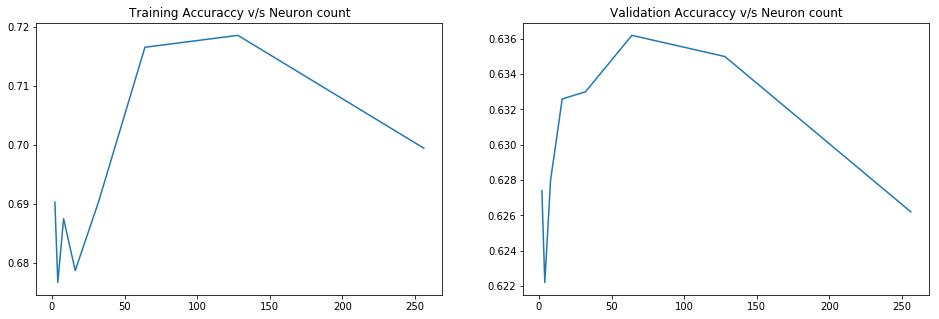

In [28]:
plt.subplot(1,2,1)
plt.title("Training Accuraccy v/s Neuron count")
plt.plot([2,4,8,16,32,64,128,256], accs)
plt.subplot(1,2,2)
plt.title("Validation Accuraccy v/s Neuron count")
plt.plot([2,4,8,16,32,64,128,256], val_accs)
plt.show()

#### 3.e Pesos de la red

Obtenga los pesos de la red entrenada a completitud anteriormente usando el método `.get_weights` y grafíque un historgrama. Note que para cada capa se obtienen por separado los pesos de los datos y del intercepto. Así en el índice 0 obtenemos los pesos de los datos de entrada, en el 1 los pesos del intercepto de entrada, en el 2 los pesos de la capa oculta y en el 3 los pesos del intercepto de la capa oculta. Solo se requiere graficar el primero.

Compare luego ese histograma con el obtenido al graficar los pesos de una red sin entrenar, como muestra el código. Discuta lo que observa. 

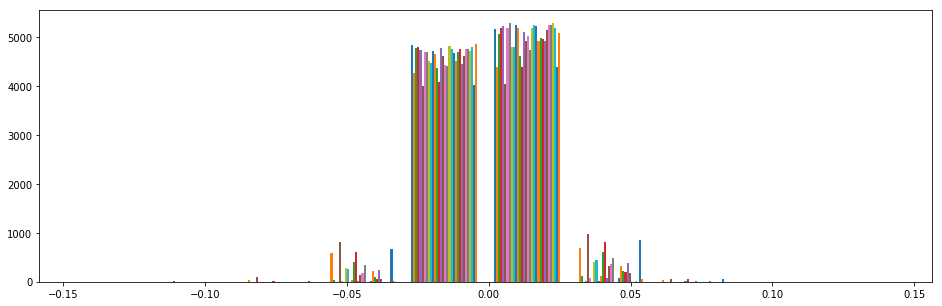

In [24]:
plt.hist(model_relu.get_weights()[0])
plt.show()

In [21]:
from keras.optimizers import SGD

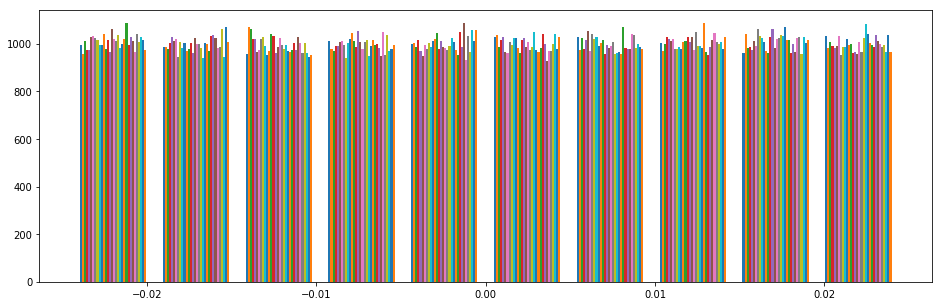

In [25]:
untrained = Sequential()
untrained.add(Dense(32, activation='relu'))
untrained.add(Dense(1,activation='sigmoid'))
untrained.compile(SGD(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
untrained.fit(x_tr,y_tr,epochs=0)  # the easy way to create the weights without training, though there are more purists ways

plt.hist(untrained.get_weights()[0])
plt.show() 
# . . . 

*Comentario:*

*Podemos observar que en el caso de los pesos sin entrenar, los valores de los pesos parecen estar todos en un rango parecido, mientras que en el caso de los pesos de la red ya entrenada, claramente se observa que hay muchos pesos que han sido anulados, pero lo que mas se nota que algunos pesos aumentan sus valores considerablemente por sobre el resto, lo que nos puede indicar que las neuronas correspondientes a estos serían las que cobran mayor importancia para la clasificación en este problema específico.*

#### 3.h Árbol

Utilizemos ahora un arbol de clasificación para tratar de resolver el problema. Para este modelo es recomendable usar los datos originales (antes de utilizar la función `to_categorical`), si bien el modelo podrá ajustarse y encontrará desempeños parecidos, el tiempo de cómputo será mucho mayor con los datos categóricos.

Luego de entrenar el árbol, calcule su _accuracy_ y compare el desempeño con las redes entrenadas anteriormente. 

In [3]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=10) #or another depth 
tree.fit(x_tr,y_tr)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [4]:
tree.score(x_val, y_val)

0.5288

*Comentario: Se aprecia que el score obtenido por el árbol es inferior al obtenido incluso por el perceptrón*

#### 3.j AdaBoost
_Adaptative Boosting_ o AdaBoost es otro meta-algoritmo que crea ensamblados a partir de modelos más simple. Entrene un modelo de AdaBoost con estimado base un árbol de baja profundidad (menor a 20) y un límite de estimadores (`n_estimators`) de a lo menos 50. 

Calcule su _accuracy_ y comparelo con los demás métodos. 

In [5]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=15), n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)
clf.fit(x_tr, y_tr)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=15,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                            

In [6]:
clf.score(x_val, y_val)

0.5574

*Comentario: El entrenamiento es muy costoso en tiempo (1 hr aprox.) para el rendimiento obtenido, siendo preferible utilizar redes neuronales para realizar predicciones*